In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.text_processing.transformations.synonyms import toy_transformation
from lr.stats.h_testing import DGP, get_matched_results, get_paired_t_statistic
from lr.stats.h_testing import get_boot_sample_under_H0,get_boot_p_value
from lr.stats.h_testing import  LIMts_test
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Loading data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(train)
pre_process_nli_df(dev)

### Training a model using one version of the modified data

In [3]:
max_features = 500
rho = 0.001
label_translation = get_ternary_label
transformation = entailment_internalization 

dgp = DGP(data=train, transformation=transformation, rho=rho)
train_t = dgp.get_sample()

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}
lr = LRWrapper(hyperparams)
lr.fit(train_t)

### Get t statistic for the observable results and matched results

In [4]:
dev_t = transformation(dev)

results = get_matched_results(dev, dev_t, lr, lr.label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-1.2964074471043285


### Get $S$ bootstrap replications under H0

In [5]:
S = 1000
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

t_boots = pd.Series(t_boots)

### Calculating the associated p-value

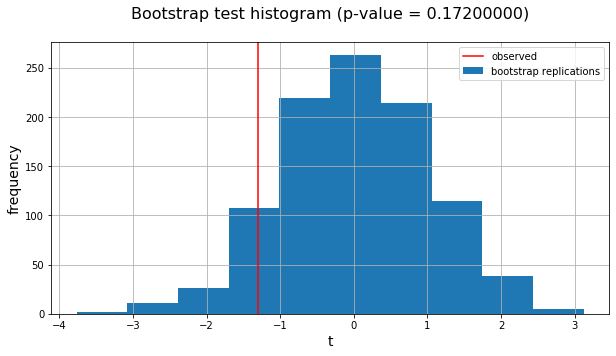

In [6]:
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");

### Performing multiple tests

**test1: entailment internalization**

In [7]:
M,E,S = 5,1,1000


tests1 = LIMts_test(train=train,
                    dev=dev,
                    transformation=entailment_internalization,
                    rho=0.78,
                    Model=LRWrapper,
                    hyperparams=hyperparams,
                    M=M,
                    E=E,
                    S=S)

tests1

,m,e,validation_accuracy,transformed_validation_accuracy,observable_t_stats,p_value,transformation_time,training_time,test_time,boot_t_1,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,1,0.310,0.550,-7.947194,0.0,0.011596,0.059425,2.189541,0.590281,...,0.566139,0.590281,-0.534905,-0.590281,-0.555127,0.149079,0.746393,-0.633089,0.603572,1.347719
1,2,1,0.310,0.515,-6.970713,0.0,0.005819,0.047955,2.178184,0.867654,...,0.316307,-1.303270,0.152507,-1.487756,-0.782062,0.687614,-0.633089,0.817861,0.000000,-0.763604
2,3,1,0.290,0.540,-8.164966,0.0,0.007228,0.056557,2.788715,-0.715199,...,-1.552301,0.963754,0.137367,-0.950825,-0.577832,0.730297,0.000000,-0.447437,-0.763604,-0.867654
3,4,1,0.325,0.575,-8.164966,0.0,0.007075,0.060547,2.681469,0.782062,...,0.149079,-0.782062,-0.457735,0.945989,-0.428768,-1.135009,-0.630567,0.301580,0.294948,0.000000
4,5,1,0.305,0.545,-7.947194,0.0,0.006939,0.059989,2.846319,0.277403,...,-0.140035,0.294948,0.149079,-0.412257,1.154622,-0.428768,-0.687614,-0.457735,-0.142864,0.000000


### Diferent bootstrap distributions for each experiment

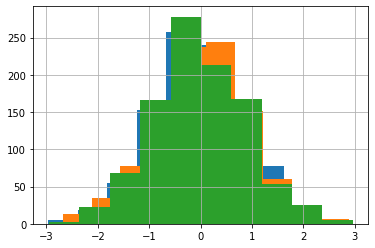

In [8]:
tests1.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

**test2: toy transformation**

In [9]:
tests2 = LIMts_test(train=train,
                   dev=dev,
                   transformation=toy_transformation,
                   rho=0.78,
                   Model=LRWrapper,
                   hyperparams=hyperparams,
                   M=M,
                   E=E,
                   S=S)

tests2

,m,e,validation_accuracy,transformed_validation_accuracy,observable_t_stats,p_value,transformation_time,training_time,test_time,boot_t_1,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,1,0.205,0.230,-1.516196,0.132,0.005717,0.046471,2.264626,-0.817861,...,1.960008,0.633089,0.000000,1.270001,1.270001,1.002509,-0.906390,-0.301580,-0.277403,1.158569
1,2,1,0.215,0.210,0.301580,0.742,0.003661,0.046892,2.510396,-1.914677,...,1.914677,0.000000,0.000000,-1.393466,-1.270001,1.137556,0.447437,1.643990,-1.002509,0.000000
2,3,1,0.210,0.215,-0.301580,0.840,0.004508,0.046590,2.289030,0.534905,...,-1.643990,1.270001,-1.158569,0.242571,-0.728572,-1.270001,1.678363,-1.002509,0.000000,0.000000
3,4,1,0.225,0.220,0.301580,0.724,0.005466,0.050515,2.464297,-1.072113,...,0.258242,-0.277403,0.333426,-2.571297,1.002509,-0.633089,0.817861,-1.516196,-1.158569,0.277403
4,5,1,0.220,0.210,0.500313,0.590,0.006248,0.054873,2.332450,0.944911,...,-0.500313,-1.745189,-0.633089,1.822336,0.258242,-1.284470,0.600541,0.534905,0.500313,-1.296407


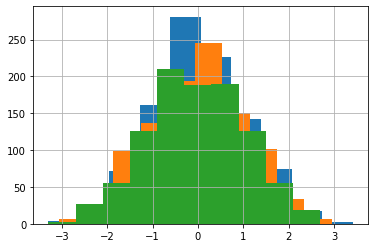

In [10]:
tests2.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

In [11]:
assert np.all(tests1.p_value < (0.05/M*E))
assert not np.all(tests2.p_value < (0.05/M*E))